# Programming Assignment

## Saving and loading models, with application to the EuroSat dataset

### Instructions

In this notebook, you will create a neural network that classifies land uses and land covers from satellite imagery. You will save your model using Tensorflow's callbacks and reload it later. You will also load in a pre-trained neural network classifier and compare performance with it. 

Some code cells are provided for you in the notebook. You should avoid editing provided code, and make sure to execute the cells in order to avoid unexpected errors. Some cells begin with the line: 

`#### GRADED CELL ####`

Don't move or edit this first line - this is what the automatic grader looks for to recognise graded cells. These cells require you to write your own code to complete them, and are automatically graded when you submit the notebook. Don't edit the function name or signature provided in these cells, otherwise the automatic grader might not function properly. Inside these graded cells, you can use any functions or classes that are imported below, but make sure you don't use any variables that are outside the scope of the function.

### How to submit

Complete all the tasks you are asked for in the worksheet. When you have finished and are happy with your code, press the **Submit Assignment** button at the top of this notebook.

### Let's get started!

We'll start running some imports, and loading the dataset. Do not edit the existing imports in the following cell. If you would like to make further Tensorflow imports, you should add them here.

In [1]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import os
import numpy as np
import pandas as pd

# If you would like to make further imports from tensorflow, add them here
import matplotlib.pyplot as plt
%matplotlib inline


![EuroSAT overview image](data/eurosat_overview.jpg)

#### The EuroSAT dataset

In this assignment, you will use the [EuroSAT dataset](https://github.com/phelber/EuroSAT). It consists of 27000 labelled Sentinel-2 satellite images of different land uses: residential, industrial, highway, river, forest, pasture, herbaceous vegetation, annual crop, permanent crop and sea/lake. For a reference, see the following papers:
- Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. Patrick Helber, Benjamin Bischke, Andreas Dengel, Damian Borth. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 2019.
- Introducing EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification. Patrick Helber, Benjamin Bischke, Andreas Dengel. 2018 IEEE International Geoscience and Remote Sensing Symposium, 2018.

Your goal is to construct a neural network that classifies a satellite image into one of these 10 classes, as well as applying some of the saving and loading techniques you have learned in the previous sessions.

#### Import the data

The dataset you will train your model on is a subset of the total data, with 4000 training images and 1000 testing images, with roughly equal numbers of each class. The code to import the data is provided below.

In [2]:
# Run this cell to import the Eurosat data

def load_eurosat_data():
    data_dir = 'data/'
    x_train = np.load(os.path.join(data_dir, 'x_train.npy'))
    y_train = np.load(os.path.join(data_dir, 'y_train.npy'))
    x_test  = np.load(os.path.join(data_dir, 'x_test.npy'))
    y_test  = np.load(os.path.join(data_dir, 'y_test.npy'))
    return (x_train, y_train), (x_test, y_test)

(x_train, y_train), (x_test, y_test) = load_eurosat_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

In [28]:
print(x_train.shape, y_train.shape)

(4000, 64, 64, 3) (4000, 1)


In [34]:
class_names = ['annual crop',
               'forest',
               'herbaceous vegetation',
               'highway',
               'industrial', 
               'pasture',
               'permanent crop',
               'residential',
               'river', 
               'sea/lake'
               ]

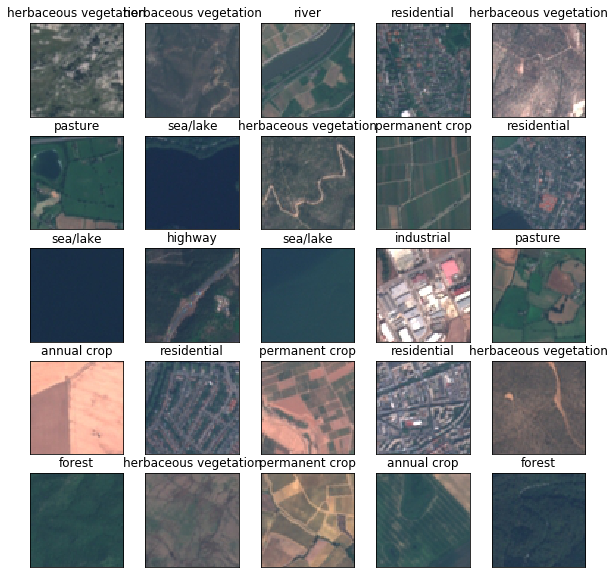

In [37]:
num_cols = 5;
num_rows = 5;

fig, ax = plt.subplots(num_rows,num_cols,figsize = (10,10))

example_i = 0
for i in range(num_rows):
    for j in range(num_cols):  
        ax[i,j].imshow(x_train[example_i,:,:,:])
        ax[i,j].set_title(class_names[y_train[example_i][0]])
        ax[i,j].get_xaxis().set_visible(False)
        ax[i,j].get_yaxis().set_visible(False)
        example_i += 1


#### Build the neural network model

You can now construct a model to fit to the data. Using the Sequential API, build your model according to the following specifications:

* The model should use the input_shape in the function argument to set the input size in the first layer.
* The first layer should be a Conv2D layer with 16 filters, a 3x3 kernel size, a ReLU activation function and 'SAME' padding. Name this layer 'conv_1'.
* The second layer should also be a Conv2D layer with 8 filters, a 3x3 kernel size, a ReLU activation function and 'SAME' padding. Name this layer 'conv_2'.
* The third layer should be a MaxPooling2D layer with a pooling window size of 8x8. Name this layer 'pool_1'.
* The fourth layer should be a Flatten layer, named 'flatten'.
* The fifth layer should be a Dense layer with 32 units, a ReLU activation. Name this layer 'dense_1'.
* The sixth and final layer should be a Dense layer with 10 units and softmax activation. Name this layer 'dense_2'.

In total, the network should have 6 layers.

In [66]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_new_model(input_shape):
    """
    This function should build a Sequential model according to the above specification. Ensure the 
    weights are initialised by providing the input_shape argument in the first layer, given by the
    function argument.
    Your function should also compile the model with the Adam optimiser, sparse categorical cross
    entropy loss function, and a single accuracy metric.
    """
    model = Sequential([
        Conv2D(16,(3,3),activation = 'relu',padding = 'SAME',input_shape = input_shape, name = 'conv_1'),
        Conv2D(8,(3,3),activation = 'relu',padding = 'SAME',name = 'conv_2'),
        MaxPooling2D((8,8), name = 'pool_1'),
        Flatten(name = 'flatten'),
        Dense(32,activation = 'relu',name = 'dense_1'),
        Dense(10,activation = 'softmax', name = 'dense_2')
    ])
    
    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',metrics = ['accuracy'])
    
    return model
    

#### Compile and evaluate the model

In [67]:
# Run your function to create the model

model = get_new_model(x_train[0].shape)

In [68]:
# Run this cell to define a function to evaluate a model's test accuracy

def get_test_accuracy(model, x_test, y_test):
    """Test model classification accuracy"""
    test_loss, test_acc = model.evaluate(x=x_test, y=y_test, verbose=0)
    print('accuracy: {acc:0.3f}'.format(acc=test_acc))

In [69]:
# Print the model summary and calculate its initialised test accuracy

model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
conv_2 (Conv2D)              (None, 64, 64, 8)         1160      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 8, 8, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                16416     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 18,354
Trainable params: 18,354
Non-trainable params: 0
__________________________________________________

In [73]:
get_test_accuracy(model, x_test, y_test)

accuracy: 0.110


#### Create checkpoints to save model during training, with a criterion

You will now create three callbacks:
- `checkpoint_every_epoch`: checkpoint that saves the model weights every epoch during training
- `checkpoint_best_only`: checkpoint that saves only the weights with the highest validation accuracy. Use the testing data as the validation data.
- `early_stopping`: early stopping object that ends training if the validation accuracy has not improved in 3 epochs.

In [74]:
print(model.metrics_names)

['loss', 'accuracy']


In [84]:
#### GRADED CELL ####

# Complete the following functions. 
# Make sure to not change the function names or arguments.

def get_checkpoint_every_epoch():
    """
    This function should return a ModelCheckpoint object that:
    - saves the weights only at the end of every epoch
    - saves into a directory called 'checkpoints_every_epoch' inside the current working directory
    - generates filenames in that directory like 'checkpoint_XXX' where
      XXX is the epoch number formatted to have three digits, e.g. 001, 002, 003, etc.
    """
    
    from tensorflow.keras.callbacks import ModelCheckpoint
    
    checkpoints_every_epoch_path = 'checkpoints_every_epoch/checkpoint_{epoch:03d}'
    checkpoints_every_epoch = ModelCheckpoint(filepath = checkpoints_every_epoch_path,
                                              save_weights_only=True,
                                              save_freq = 'epoch',
                                              verbose = 1)
    return checkpoints_every_epoch

def get_checkpoint_best_only():
    """
    This function should return a ModelCheckpoint object that:
    - saves only the weights that generate the highest validation (testing) accuracy
    - saves into a directory called 'checkpoints_best_only' inside the current working directory
    - generates a file called 'checkpoints_best_only/checkpoint' 
    """
    from tensorflow.keras.callbacks import ModelCheckpoint
    
    checkpoints_best_only_path = 'checkpoints_best_only/checkpoint'
    checkpoints_best_only = ModelCheckpoint(filepath = checkpoints_best_only_path,
                                            save_weights_only= True,
                                            save_best_only = True,
                                            monitor = 'val_accuracy',
                                            mode = 'max',
                                            save_freq = 'epoch',
                                            verbose = 1)
    return checkpoints_best_only

In [85]:
#### GRADED CELL ####

# Complete the following function. 
# Make sure to not change the function name or arguments.

def get_early_stopping():
    """
    This function should return an EarlyStopping callback that stops training when
    the validation (testing) accuracy has not improved in the last 3 epochs.
    HINT: use the EarlyStopping callback with the correct 'monitor' and 'patience'
    """
    
    from tensorflow.keras.callbacks import EarlyStopping
    
    early_stopping_CB = EarlyStopping(monitor = 'val_accuracy',
                                      patience = 3,
                                      mode = 'max')
    
    return early_stopping_CB

In [86]:
# Run this cell to create the callbacks

checkpoint_every_epoch = get_checkpoint_every_epoch()
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()

#### Train model using the callbacks

Now, you will train the model using the three callbacks you created. If you created the callbacks correctly, three things should happen:
- At the end of every epoch, the model weights are saved into a directory called `checkpoints_every_epoch`
- At the end of every epoch, the model weights are saved into a directory called `checkpoints_best_only` **only** if those weights lead to the highest test accuracy
- Training stops when the testing accuracy has not improved in three epochs.

You should then have two directories:
- A directory called `checkpoints_every_epoch` containing filenames that include `checkpoint_001`, `checkpoint_002`, etc with the `001`, `002` corresponding to the epoch
- A directory called `checkpoints_best_only` containing filenames that include `checkpoint`, which contain only the weights leading to the highest testing accuracy

In [87]:
! rm -r checkpoints_every_epoch
! rm -r checkpoints_best_only

In [88]:
# Train model using the callbacks you just created

callbacks = [checkpoint_every_epoch, checkpoint_best_only, early_stopping]
model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), callbacks=callbacks)

Train on 4000 samples, validate on 1000 samples
Epoch 1/50
3968/4000 [============================>.] - ETA: 0s - loss: 1.3104 - accuracy: 0.4980
Epoch 00001: saving model to checkpoints_every_epoch/checkpoint_001

Epoch 00001: val_accuracy improved from -inf to 0.46900, saving model to checkpoints_best_only/checkpoint
4000/4000 [==============================] - 85s 21ms/sample - loss: 1.3117 - accuracy: 0.4970 - val_loss: 1.2874 - val_accuracy: 0.4690
Epoch 2/50
3968/4000 [============================>.] - ETA: 0s - loss: 1.2216 - accuracy: 0.5358
Epoch 00002: saving model to checkpoints_every_epoch/checkpoint_002

Epoch 00002: val_accuracy improved from 0.46900 to 0.55000, saving model to checkpoints_best_only/checkpoint
4000/4000 [==============================] - 82s 21ms/sample - loss: 1.2214 - accuracy: 0.5365 - val_loss: 1.2060 - val_accuracy: 0.5500
Epoch 3/50
3968/4000 [============================>.] - ETA: 0s - loss: 1.1618 - accuracy: 0.5743
Epoch 00003: saving model to ch

#### Create new instance of model and load on both sets of weights

Now you will use the weights you just saved in a fresh model. You should create two functions, both of which take a freshly instantiated model instance:
- `model_last_epoch` should contain the weights from the latest saved epoch
- `model_best_epoch` should contain the weights from the saved epoch with the highest testing accuracy

_Hint: use the_ `tf.train.latest_checkpoint` _function to get the filename of the latest saved checkpoint file. Check the docs_ [_here_](https://www.tensorflow.org/api_docs/python/tf/train/latest_checkpoint).

In [90]:
#### GRADED CELL ####

# Complete the following functions. 
# Make sure to not change the function name or arguments.

def get_model_last_epoch(model):
    """
    This function should create a new instance of the CNN you created earlier,
    load on the weights from the last training epoch, and return this model.
    """
    
    checkpoints_every_epoch_path = 'checkpoints_every_epoch/'
    latest_checkpoint = tf.train.latest_checkpoint(checkpoints_every_epoch_path)
    
    model.load_weights(latest_checkpoint)
    
    return model
    
    
def get_model_best_epoch(model):
    """
    This function should create a new instance of the CNN you created earlier, load 
    on the weights leading to the highest validation accuracy, and return this model.
    """
    
    checkpoints_best_only_path = 'checkpoints_best_only/'
    latest_checkpoint = tf.train.latest_checkpoint(checkpoints_best_only_path)
    
    model.load_weights(latest_checkpoint)
    
    return model
    

In [91]:
# Run this cell to create two models: one with the weights from the last training
# epoch, and one with the weights leading to the highest validation (testing) accuracy.
# Verify that the second has a higher validation (testing) accuarcy.

model_last_epoch = get_model_last_epoch(get_new_model(x_train[0].shape))
model_best_epoch = get_model_best_epoch(get_new_model(x_train[0].shape))
print('Model with last epoch weights:')
get_test_accuracy(model_last_epoch, x_test, y_test)
print('')
print('Model with best epoch weights:')
get_test_accuracy(model_best_epoch, x_test, y_test)

Model with last epoch weights:
accuracy: 0.678

Model with best epoch weights:
accuracy: 0.678


#### Load, from scratch, a model trained on the EuroSat dataset.

In your workspace, you will find another model trained on the `EuroSAT` dataset in `.h5` format. This model is trained on a larger subset of the EuroSAT dataset and has a more complex architecture. The path to the model is `models/EuroSatNet.h5`. See how its testing accuracy compares to your model!

In [107]:
#### GRADED CELL ####

# Complete the following functions. 
# Make sure to not change the function name or arguments.

def get_model_eurosatnet():
    """
    This function should return the pretrained EuroSatNet.h5 model.
    """
    
    from tensorflow.keras.models import Sequential, load_model
    
    EuroSatNet_model = load_model('models/EuroSatNet.h5')
    return EuroSatNet_model
    
    

In [108]:
# Run this cell to print a summary of the EuroSatNet model, along with its validation accuracy.

model_eurosatnet = get_model_eurosatnet()
model_eurosatnet.summary()
get_test_accuracy(model_eurosatnet, x_test, y_test)

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 64, 64, 16)        448       
_________________________________________________________________
conv_2 (Conv2D)              (None, 64, 64, 16)        6416      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 32, 32, 16)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 32, 32, 16)        2320      
_________________________________________________________________
conv_4 (Conv2D)              (None, 32, 32, 16)        6416      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 16, 16, 16)        0         
_________________________________________________________________
conv_5 (Conv2D)              (None, 16, 16, 16)      

Congratulations for completing this programming assignment! You're now ready to move on to the capstone project for this course.